PC

## -*- coding: utf-8 -*-
# PC_

## Import

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F  # F.mse_loss
import torch.optim as optim
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader  # for batch and split Xtrain Ytrain dataset

import scipy
import scipy.ndimage as nd
from scipy.stats import norm
from scipy.optimize import minimize

from locale import format
from dataclasses import dataclass, MISSING

import seaborn as sns
import plotly.graph_objects as go


from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
# from scipy.sparse import identity
from icecream import ic  # for debugging. print variable name

## !!!!! To get the parameters
from PC_Parameters import default_parameters_network

pars = default_parameters_network()


{'ae': 18.26, 'be': -5.38, 'hme': 78.67, 'ai': 21.97, 'bi': -4.81, 'hmi': 125.62, 'taue': 0.005, 'taui': 0.005, 'tauNMDA': 0.1, 'tauGABA': 0.005, 'tauAMPA': 0.002, 'gamma': 0.641, 'sigma': 0.0007, 'I0e': 0.2346, 'I0i': 0.17, 'sigmaIn': 3, 'sigmaEI': 3, 'sigmaInh': [0.2, 3], 'I_ext': 0.0, 'c_dash': 90, 'mu0': 30, 'Jext': 0.01, 'I1': 0.57, 'I2': 0.029999999999999992, 'Jee': 0.2, 'Jie': 0.2, 'Jei': 1.4, 'Jii': 6.7, 'Jin': 0.008, 'Jiq': 0.85, 'Jes': 3.5, 'Jsi': 0.12, 'Jem': 2.2, 'I_noise': array([[0.00024033],
       [0.00012059],
       [0.00094191],
       [0.00055949]]), 'T': 3, 'dt': 2e-05, 'r_init': 0.2, 'range_t': array([0.00000e+00, 2.00000e-05, 4.00000e-05, ..., 2.99994e+00,
       2.99996e+00, 2.99998e+00]), 'Lt': 150000, 'NumN': 20, 'f': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]), 'In0': 0, 'InMax': 50, 'Iq0': 0, 'IqMax': 10}


## Functions
### Basics ones

In [2]:
#### 2- Input/Output function

def plot_io(x, y, sign):
    if sign == "+":
        sign_name = 'Excitatory'
        label = "ae={0}, be={1}, hme={2}"
        a, b, hm = pars['ae'], pars['be'], pars['hme']
        color = "k"
    elif sign == "-":
        sign_name = 'Inhibitory'
        label = "ai={0}, bi={1}, hmi={2}"
        a, b, hm = pars['ai'], pars['bi'], pars['hmi']
        color = "r"

    plt.plot(x, y, color, label=label.format(a, b, hm))

    plt.xlabel("Input values - nA")
    plt.ylabel("Spike Frequency - Hz")
    plt.xlim([-0.01, 1])
    plt.title("Input-output function")
    # plt.title("{0} Input-output function".format(sign_name))
    plt.legend()


def plot_r(range_sim, r_e, r_i, param, xlim_ar=None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"  # , I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"  # , I2={2}"
    plt.plot(range_sim, r_e, "r", label=label_e.format(param.Jee, param.Jei))  # , param.I1 #, param.In
    plt.plot(range_sim, r_i, "orange", label=label_i.format(param.Jii, param.Jie))  # , round(param.I2, 2)))

    plt.xlabel("Time - ms")
    plt.ylabel("Spike Frequency - Hz")
    if xlim_ar != None:
        plt.xlim(xlim_ar)  # [0, .1]
    plt.title("Firing rate of the NMDA and GABA populations")
    plt.legend()


def plot_s(range_sim, S_e, S_i, param, xlim_ar=None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"  # , I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"  # , I2={2}"
    plt.plot(range_sim, S_e, "olive", label=label_e.format(param.Jee, param.Jei))  # , param.I1
    plt.plot(range_sim, S_i, "green", label=label_i.format(param.Jii, param.Jie))  # , round(param.I2, 2)
    if xlim_ar != None:
        plt.xlim(xlim_ar)
    plt.xlabel("Time - ms")
    plt.ylabel("Open channel")
    # plt.xlim([0, .1])
    plt.title("Average open channel for the NMDA and GABA populations")
    plt.legend()


# 2- Plot HeatMap of firing rate function
def HeatMap(rE, rI, J=None):
    if J == None:
        J = [.00989, 0.0081, .1, .87, .00081]  # J = dict(Jin=.008, Jee= .2, Jie=.2, Jei=1.4, Jii=6.7)
    if type(J) == dict:
        J = np.array(list(J.values()))

    rE_df = pd.DataFrame(rE.T)  # to get time vs pop
    rI_df = pd.DataFrame(rI.T)

    rE_df.index.name, rI_df.index.name = ["Excitatory Population", "Inhibitory Population"]
    rE_df.columns.name, rI_df.columns.name = ["Time s", "Time s"]
    # print(rE_df.loc[[10]])

    # set context for the upcoming plot
    sns.set_context("notebook", font_scale=.8, rc={"lines.linewidth": 2.5, 'font.family': 'Helvetica'})

    fig, (axA, axB) = plt.subplots(2, 1, figsize=(6, 6))

    sns.heatmap(rE_df, ax=axA, cmap="viridis")
    sns.heatmap(rI_df, ax=axB)
    axA.set_title(f"Firing rate in Hz of exc populations over time. Jie: {J[2]}, Jee: {J[1]}, Jin: {J[0]}",
                  fontdict={"fontsize": 10})
    axB.set_title(f"Firing rate in Hz of inh populations over time. Jei: {J[3]}, Jii: {J[4]}",
                  fontdict={"fontsize": 10})
    plt.tight_layout()

    plt.show()


# Filters gauss and Dog and LoG
def gaussian_filter(s, N):
    k = np.arange(1, N + 1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * s ** 2))
    gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW))  # 1
    return gaussW2


def dog_filter(sOut, N):
    sIn = sOut / 30
    k = np.arange(1, N + 1)
    gaussIn = np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * sIn ** 2))
    gaussOut = np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * sOut ** 2))
    dog = gaussOut - gaussIn
    if np.max(dog) == 0 or None:
        print('zero max')
        dog = 0
    else:
        dog = dog / (.042 ** 2 / np.max(dog))  # .0088
    return dog


def LoG_filter(s, N):
    x_lap = np.eye(N)
    lapl_filter = nd.gaussian_laplace(x_lap, sigma=(s, s))
    return lapl_filter


def dLogGaus(s=.61, N=20):
    dig = LoG_filter(s, N) + gaussian_filter(.019 * s, N)
    return dig


"""### Differentiable function for back propagation

To avoid non-differentiable araising from discontinuity of the function, I "relax" (smoothen) the where() expression by using a sigmoid instead
*   with grad_fn:
*   if I get : > <SumBackward1 object at 0x7f79da0b9520> # differentiable
*   else I get none
"""


def relu_stim(x, stim):
    return torch.nn.functional.relu(1.0 - torch.abs(x - stim),
                                    inplace=False)  # inplace = False to avoid implace operation




def Dirac(A, N=pars["NumN"]):
    y = scipy.signal.unit_impulse(N, idx=(torch.max(torch.argmax(A))))  # , dtype= <class 'float'>)
    return torch.tensor(y)



"""### Try Normalization to "make it proba"
"""


def make_it_proba(r_e):
    sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
    prob_r = torch.div(r_e, sum_r_e)  
    print(prob_r.grad_fn)
    prob_r[prob_r != prob_r] = 0.05  # to replace nan to 1/20 - to sum to 1
    # print("should sum to 1:", torch.sum(prob_r, 1)) #to check that it worked

    return prob_r.reshape(r_e.shape[0], r_e.shape[1])  # log or not log?


def make_it_proba_1d(r_e):
    sum_r_e = torch.sum(r_e)
    prob_r = torch.div(r_e, sum_r_e)  # torch.transpose(r_e, dim0=0 ,dim1=1) poses a problem
    prob_r[prob_r != prob_r] = 0.05  # to replace nan to 1/20 - to sum to 1
    print("should sum to 1:", torch.sum(prob_r)) #to check that it worked

    return prob_r


def log_proba(proba_r):
    return torch.log(proba_r)


"""### Try softmax to "make it proba"
"""


def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdims=True)

def softmax1D(x):
    return torch.exp(x) / torch.sum(torch.exp(x))

"""### Get the expected stimuli : matrix of 1 where stimuli 0 elsewhere"""


# find the stimuli for every X = stim dataset
# find the stimuli for every X = stim dataset
def get_stimuli_input(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor, dim=1)
    Xmax = torch.max(Xargmax)
    return Xmax

def get_stimuli_input1D(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor)#, dim=1)
    Xmax = torch.max(Xargmax)
    return Xmax


# replace where function by relu functio which is differentiable
def get_expected_Y_relu(X_train_tensor):
    x_t = torch.transpose(X_train_tensor, 0, 1)
    dirac_2d = torch.zeros(x_t.shape)
    stim = get_stimuli_input(
        X_train_tensor)  # input of the shape Xtrain_tensor[5,:,:] # here get_stimuli not differenciable

    for pop, t in enumerate(x_t):
        tpop = torch.tensor(pop)
        dirac_2d[pop, :] = torch.nn.functional.relu(1.0 - torch.abs(tpop - stim), inplace=False).requires_grad_(False)
    dirac_2d = torch.transpose(dirac_2d, 1, 0)
    return dirac_2d


def get_expected_Y_relu_1d_where(X_train_tensor):
    stim = get_stimuli_input1D(X_train_tensor)
    dirac_1d = torch.zeros(X_train_tensor.shape)
    # Calculate the difference between tpop and stim
    for pop in enumerate(X_train_tensor):
        dirac_1d[pop[0]] = torch.where(pop[0] == torch.tensor(stim), torch.tensor(1.0), torch.tensor(0.0)).requires_grad_(False)#true #not differenciable
    return dirac_1d




## Class

### 1- Basic classes

In [3]:


# ***************** CLASS ***************************************

@dataclass
class Parameter:
    # °°° Load the parameters °°°

    taue: float = pars["taue"]
    ae: float = pars['ae']
    be, hme, I_noise = pars['be'], pars['hme'], pars['I_noise']
    Jee: float = pars['Jee']
    taui, ai, bi, hmi = pars['taui'], pars['ai'], pars['bi'], pars['hmi']
    Jii: float = pars['Jii']
    Jei: float = pars['Jei']
    Jie: float = pars['Jie']
    Jes, Jsi = pars['Jes'], pars['Jsi']
    Jiq: float = pars['Jiq']  # 0.85; #nA
    Jin: float = pars['Jin']
    tauNMDA, tauAMPA, tauGABA = pars['tauNMDA'], pars['tauAMPA'], pars['tauGABA']
    gamma: float = pars['gamma']  # nmda coupling parameter from brunel
    c_dash = pars['c_dash']
    sigma = pars['sigma']  # param.sigma = .0007 for Noise
    I_noise = pars['sigma'] * np.random.randn(3, 1)
    I1 = pars['Jext'] * pars['mu0'] * (1 + pars['c_dash'] / 100)
    I2 = pars['Jext'] * pars['mu0'] * (1 - pars['c_dash'] / 100)
    # I1, I2 = pars['I1'], pars['I2']

    sigmaIn = pars['sigmaIn']

    # Input parameters
    In0 = pars['In0']  # % Spontaneous firing rate of input populations (Hz)
    InMax = pars['InMax']  # % Max firing rate of input populations (Hz)
    Iq0 = pars['Iq0']  # % Spontaneous firing rate of feedback populations (Hz)
    IqMax = pars['IqMax']  # % Max firing rate of feedback populations (Hz)

    # Gaussian filter
    # sIn = pars['sigmaInh'][0]
    # sOut = pars['sigmaInh'][1]

    def __init__(self, sEI, sIn, sOut, N):  # sEI=4, sIn=.2, sOut=1.2,
        # Weights (from gaussian filter)
        self.N = N  # pars['NumN']
        self.wei = torch.tensor(dog_filter(sOut, int(N)), dtype=torch.float32)   # .astype( torch.float32))  # , dtype='float64'# fun.dLogGaus(.61, N)  #fun.dog_filter(sIn, sOut, N)#gaussian_filter(sEI, N)
        self.wii = torch.tensor(np.eye(int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(sEI, int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(N)), dtype=torch.float32)  #.astype(torch.float32))  # Identity matrix
        self.f = np.arange(1, N + 1)
        self.sEI = sEI
        self.sIn = sIn
        self.sOut = sOut

    def reset(self):  # https://stackoverflow.com/questions/56878667/setting-default-values-in-a-class

        for name, field in self.__dataclass_fields__.items():
            if field.default != MISSING:
                setattr(self, name, field.default)
            else:
                setattr(self, name, field.default_factory())


# °°° Time of the simulation °°°
class Simulation:
    def __init__(self, dt, T):
        self.dt = dt
        self.T = T
        self.range_t = (np.arange(0, self.T, self.dt))
        self.Lt = self.range_t.size

    def printSim(self):
        print("T time step of the simulation (dt): ", self.dt, "  Duration of simulation S (T): ", self.T,
              "Length of the time frame (Lt): ", self.Lt)


#  °°° Initialisation of the variables °°°

class Stim:
    def __init__(self, param, simu, f, ISI=1, dur=0.2):  # 8 #[10]
        self.f = f  # array of frequency stimulus types
        self.ISI = ISI  # inter-stimulus interval
        self.dur = dur  # duration in s of a specific stimulus segment . The time the frequency fi ll be maintained in the f array
        self.tail = 0
        self.predDt = 0
        self.pred = 0
        self.InMax = param.InMax
        self.In0 = param.In0

        # Instantaneous frequency
        f_instant = np.zeros((int(self.ISI / simu.dt) + 1, 1))  # size ISI : 1 /dt : 1000

        for fx in self.f:
            fx_array = np.concatenate((np.ones((int(self.dur / simu.dt), 1)) * fx,
                                       # just 1 frequency of 8 . # inter-stim interval is aslong as stim interval
                                       np.zeros((int(self.ISI / simu.dt),
                                                 1))))  # so I get 1 list with 1000 lists containing 8 and 1000 lists containing 0
        f_stim = np.vstack((f_instant, fx_array))  # stack vertically these arrays # [0] *1000 , [8]*1000, [0]*1000
        self.f_stim = f_stim[1:]  # 1400*1

    # bottom up sensory Input # duration 1sec
    def sensoryInput(self, parameter, simu, sigmaIn=None, paramf=None, f_stim=None, InMax=None, In0=None):
        # paramf = np.arange(1, 101)
        w = np.exp(-(((paramf or parameter.f) - (f_stim or self.f_stim)) ** 2) / (
                2 * (sigmaIn or parameter.sigmaIn) ** 2))  # pars['f'] = 1:N

        # totalAct = w.sum(axis = 1) #sum over each row
        # norm_w = (w.T / totalAct).T # elementwise division
        In = np.where(f_stim or self.f_stim > 0, (InMax or self.InMax) * w + (In0 or self.In0),
                      0)  # if stim >0 give InMax * weight + In0 otherwise give 0
        if self.tail != 0:
            tail_zeros = np.zeros((parameter.N, int(self.tail / simu.dt)))
            In = np.hstack((In, tail_zeros))

        range_sim = np.arange(1, In.shape[0] + 1)
        self.In = In
        self.w = w
        self.sigmaIn = sigmaIn

        return In, range_sim, w, sigmaIn

    def printStim(self):
        print("frequence of stimulus f:", self.f, "  ISI:", self.ISI, " Size In:", self.In.shape, "Size w:",
              self.w.shape, "  f_stim:", self.f_stim.shape,
              "sigmaIn:", self.sigmaIn)




### 2- Model Classes

My model without time

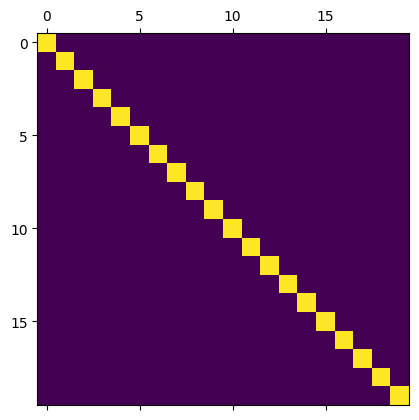

In [4]:
sEI = .2
wii = torch.tensor(np.eye(int(20)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)#np.eye(N) #
wie = torch.tensor(gaussian_filter(sEI, int(20)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
wes = torch.tensor(np.eye(int(20)), dtype=torch.float32)  #.

plt.matshow(wie) 

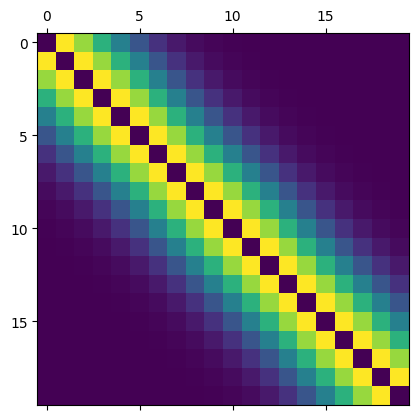

In [5]:
sOut = 3.
wei =torch.tensor(dog_filter(sOut, int(20)), dtype=torch.float32)  
plt.matshow(wei) 
#plt.matshow(mymodel.wei) #wii as identity . matrix Jii = 0

In [6]:
class MyModel_time(nn.Module):
    def __init__(self): 
        super(MyModel_time, self).__init__()
      
        #--- Define other model parameters, layers, or components here if needed
        self.dt = torch.tensor(1e-4) #sim.dt 
        self.N = 20 
        self.taue = self.taui = torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(78.67)
        self.ai = torch.tensor(21.97)
        self.bi = torch.tensor(-4.81)
        self.hmi = torch.tensor(125.62)
        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002) 
        self.tauGABA = torch.tensor(0.005)
        
        self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)   
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  #.astype(torch.float32))  # Identity matrix


        self.Jee = nn.Parameter(torch.tensor(0.072, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei =nn.Parameter(torch.tensor(0.004, requires_grad= True, dtype= torch.float64)) 
        self.Jie = nn.Parameter(torch.tensor(0.05, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.6, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.00695, requires_grad= True, dtype=torch.float64))
        #self.newfactor = nn.Parameter(torch.tensor(10000., requires_grad= True, dtype=torch.float64)) #I have to scale this mock model with this new factor
        self.epsilon = sys.float_info.epsilon
    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
        """neg_mulA_I = torch.neg(torch.multiply(a, I_tot))
        exp_b = torch.exp(torch.add(neg_mulA_I, b))
        divide_and_one = torch.divide(1, torch.add(exp_b, 1))
        mul_hm = torch.mul(hm, divide_and_one) #mul_hm"""
        
        multi= torch.nan_to_num((torch.mul(a, I_tot) + b), nan = self.epsilon, posinf=9999999, neginf=- 9999999) #self.epsilon
        #multi= (torch.mul(a, I_tot) + b)#torch.nan_to_num(, nan = .5, posinf=.5, neginf=.5)
        expo = torch.exp(- (multi)) #.abs()+ self.epsilon)
    
        return torch.multiply(hm, torch.divide(1, (1+ expo)))  #torch.multiply(hm, torch.divide(torch.ones(1), (torch.add(torch.ones(1), torch.exp(torch.add(torch.neg(torch.multiply(a, I_tot)), b)))

    def forward(self, In):
        #--- Initialize model variables here
        prev_r_e = torch.zeros((In.shape[0], self.N)) # torch.ones(self.N) shows more obvious results
        prev_r_i = torch.zeros((In.shape[0], self.N)) 
        #ic(prev_r_e.grad_fn)
        prev_s_ampa = torch.zeros((In.shape[0], self.N)) 
        prev_s_gaba = torch.zeros((In.shape[0], self.N)) 
        s_ampa = torch.tensor(0.)
        
        for k in range(1, In.shape[0]):
            #--- Compute values of interest
            #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
            # i_tot_e[k, :] = self.Jee * s_ampa[k - 1, :] - (self.Jie * s_gaba_wie) + self.Jin * In[k - 1, :]
            # i_tot_i[k, :] = (self.Jei * s_ampa_wei) - (self.Jii * s_gaba_wii)
            s_gaba_wie = prev_s_gaba[k-1,:] @ self.wie  # replaced torch.matmul() by @
            s_ampa_wei = prev_s_ampa[k-1,:] @ self.wei  # @ is an inplace operation!
            s_gaba_wii = prev_s_gaba[k-1,:] @ self.wii 

            JeeAmpa =  torch.mul(self.Jee, s_ampa)
            i_tot_e = torch.add(torch.subtract(torch.mul(JeeAmpa, self.Jee), torch.mul(s_gaba_wie, self.Jie)), torch.mul(In[k-1,:], self.Jin))
            #ic(i_tot_e.grad_fn)
            i_tot_i = torch.subtract(torch.mul(s_ampa_wei,self.Jei), torch.mul(s_gaba_wii,self.Jii))

            phi_arr_e = self.phi(i_tot_e, self.ae, self.be, self.hme)
            phi_arr_i = self.phi(i_tot_i, self.ai, self.bi, self.hmi)
            #ic(phi_arr_e.grad_fn)
            

            dr_e_dt = (-prev_r_e[k - 1, :] + phi_arr_e) / self.taue#Jee*r remove pi and S
            dr_i_dt = (-prev_r_i[k - 1, :] + phi_arr_i) / self.taui

            r_e = prev_r_e[k - 1, :] + dr_e_dt * self.dt
            r_i = prev_r_i[k - 1, :] + dr_i_dt * self.dt

            dS_amp_dt = (- prev_s_ampa[k - 1, :] / self.tauAMPA) + r_e
            s_ampa = prev_s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- prev_s_gaba[k - 1, :] / self.tauGABA) + r_i
            s_gaba = prev_s_gaba[k - 1, :] + dS_gab_dt * self.dt
            
            prev_r_e[k,:] = r_e
            prev_r_i[k,:] = r_i
            prev_s_ampa[k,:] = s_ampa
            prev_s_gaba[k,:] = s_gaba

            #ic(dS_gab_dt.grad_fn, s_gaba.grad_fn)

      
            
        return prev_r_e, prev_r_i
    
    

In [7]:
 
            #Sampa_Jee = self.Jee * s_ampa[k - 1, :]  # self.Jee.clone() destroys the gradient
            #In_Jin = self.Jin * stim[k - 1, :]
            # ic(Sampa_Jee.grad_fn)
            ##Jee *r depend on r # 
            #i_tot_e[k, :] = self.Jee * s_ampa[k - 1, :] - (self.Jie * s_gaba_wie) + self.Jin * In[k - 1, :]
            #i_tot_i[k, :] = (self.Jei * s_ampa_wei) - (self.Jii * s_gaba_wii)

"""
            phi_arr_e = self.phi(i_tot_e[k, :], self.param.ae, self.param.be, self.param.hme)
            phi_arr_i = self.phi(i_tot_i[k, :], self.param.ai, self.param.bi, self.param.hmi)

            dr_e_dt[k, :] = (-r_e[k - 1, :] + phi_arr_e) / self.param.taue#Jee*r remove pi and S
            dr_i_dt[k, :] = (-r_i[k - 1, :] + phi_arr_i) / self.param.taui

            r_e[k, :] = r_e[k - 1, :] + dr_e_dt[k, :] * self.dt
            r_i[k, :] = r_i[k - 1, :] + dr_i_dt[k, :] * self.dt

            dS_amp_dt = (- s_ampa[k - 1, :] / self.param.tauAMPA) + r_e[k, :]
            s_ampa[k, :] = s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- s_gaba[k - 1, :] / self.param.tauGABA) + r_i[k, :]
            s_gaba[k, :] = s_gaba[k - 1, :] + dS_gab_dt * self.dt

"""

'\nphi_arr_e = self.phi(i_tot_e[k, :], self.param.ae, self.param.be, self.param.hme)\nphi_arr_i = self.phi(i_tot_i[k, :], self.param.ai, self.param.bi, self.param.hmi)\n\ndr_e_dt[k, :] = (-r_e[k - 1, :] + phi_arr_e) / self.param.taue#Jee*r remove pi and S\ndr_i_dt[k, :] = (-r_i[k - 1, :] + phi_arr_i) / self.param.taui\n\nr_e[k, :] = r_e[k - 1, :] + dr_e_dt[k, :] * self.dt\nr_i[k, :] = r_i[k - 1, :] + dr_i_dt[k, :] * self.dt\n\ndS_amp_dt = (- s_ampa[k - 1, :] / self.param.tauAMPA) + r_e[k, :]\ns_ampa[k, :] = s_ampa[k - 1, :] + dS_amp_dt * self.dt\n\ndS_gab_dt = (- s_gaba[k - 1, :] / self.param.tauGABA) + r_i[k, :]\ns_gaba[k, :] = s_gaba[k - 1, :] + dS_gab_dt * self.dt\n\n'

## Call the classes to make the Input matrix (In)


tensor(27.0990, grad_fn=<MaxBackward1>)


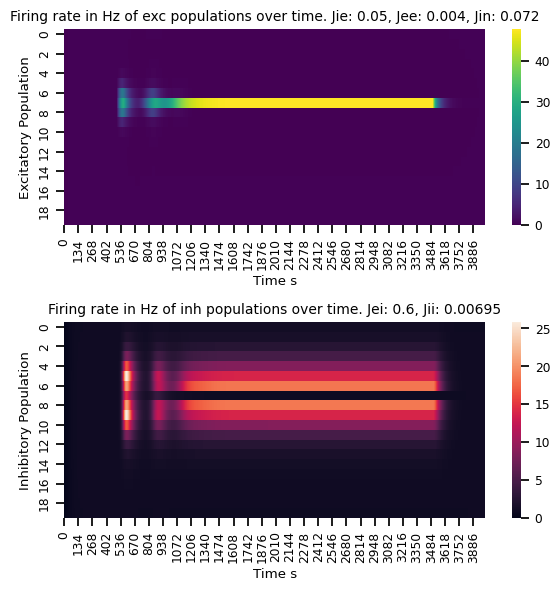

In [8]:
## Parameters used to create In
N = 20
# \\\\\\\\\\\ Parameters
param = Parameter(N=20, sIn=.1, sOut=3., sEI=.2)
# \\\\\\\\\\\ Simulation time
simu = Simulation(1e-4, .4)  # dt #rangeSim #dur = 2s

# \\\\\\\\\\\ Bottom up sensory input
stimuli = Stim(param, simu, dur=.3, f=[8], ISI=.05)  # dur = 1s Isi=1s
In, range_sim, w, sigmaIn = stimuli.sensoryInput(param, simu, sigmaIn=2.)

J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
J_list = list(J1.keys())


mymodel = MyModel_time()



# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sti = torch.tensor(stimuli.In, dtype=torch.float32)
r_e, r_i = mymodel.forward(sti)
print(torch.max(r_e[1000,:]))
HeatMap(r_e.detach().numpy(), r_i.detach().numpy(), J1)

## Optimization steps

### Parameters Initialization

In [14]:
# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++

# +++++++++++++++++++++++++ Optimizer ++++++++++++++++++++++++++++
learning_rate = 0.01
optimizer = optim.SGD(mymodel.parameters(),
                      lr=learning_rate)
# +++++++++++++++++++++++++ Epochs +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
num_epochs = 100

# +++++++++++++++++++++++++ Inputs + Labels +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#X_input = make_it_proba(torch.tensor(stimuli.In)) #make I at time 1000ms a probability function
X_input = sti

Y_target = get_expected_Y_relu(X_input) #get the expected dirac delta for our particular Input
losses = torch.zeros(num_epochs) # used to plot the loss at the end

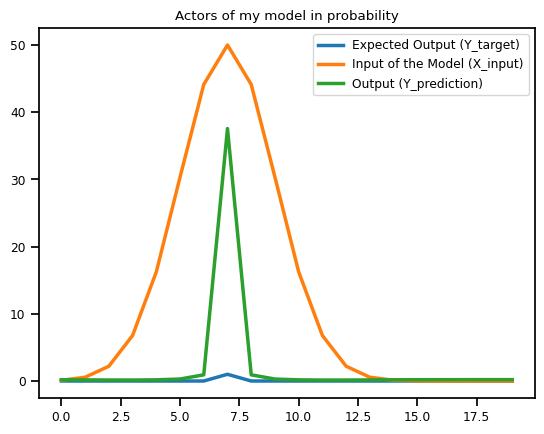

In [15]:

plt.plot(np.arange(0,20),Y_target[1000,:].detach().numpy(), label = "Expected Output (Y_target)")
plt.plot(np.arange(0,20), X_input[1000,:].detach().numpy(), label = "Input of the Model (X_input)")
plt.plot(np.arange(0,20),r_e[1100,:].detach().numpy(), label = "Output (Y_prediction)")

plt.title("Actors of my model in probability")
plt.legend()

### Optimization steps

In [16]:
# +++++++++++++++++++++++++ Problems investigations +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# import tracemalloc
# tracemalloc.start()
#mymodel2.train()

# +++++++++++++++++++++++++ Optimization loop +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
with torch.autograd.set_detect_anomaly(False):
    for epoch in range(num_epochs):
        # Create a new input tensor for each epoch
        X_input.requires_grad = False 
        # Clear the gradients 
        optimizer.zero_grad()

        # calculate output
        Y_prediction, I = mymodel(X_input) 
        Y_prediction_prob = make_it_proba(Y_prediction)
        ic(Y_prediction.grad_fn)
        
        # calculate loss
        loss1D = (torch.mean((Y_prediction_prob - Y_target)**2))  
        ic(loss1D.grad_fn)
        loss1D.backward()
        
        optimizer.step()

        losses[epoch] = loss1D
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss1D}, Loss_grad: {loss1D.grad}')  # .item()
        for i, par in enumerate(mymodel.parameters()):
           ic(J_list[i], par, par.grad)
     


ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75F7AF0>


ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75F4C40>
C:\Users\knzga\AppData\Local\Temp\ipykernel_13488\3384911261.py:27: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss1D}, Loss_grad: {loss1D.grad}')  # .item()
ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(7.4468e-06, dtype=torch.float64)
ic| J_list[i]

Epoch [1/100], Loss: 0.012873668223619461, Loss_grad: None


: 'Jei'
    par: Parameter containing:
         tensor(0.0155, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0878, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0500, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0114, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0005, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0388, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0069, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>


ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE74DB190>
ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(6.5011e-06, dtype=torch.float64)


Epoch [2/100], Loss: 0.012795550748705864, Loss_grad: None


ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0164, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0857, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0499, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0118, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0005, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0389, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0071, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE74DB190>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(5.5399e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0172, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0820, dtype=torch.float64)


Epoch [3/100], Loss: 0.012721691280603409, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0498, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0122, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0005, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0390, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0076, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D99F0>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.6572e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0180, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0762, dtype=torch.float64)


Epoch [4/100], Loss: 0.01265430822968483, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0497, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0123, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0005, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0390, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0083, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D9150>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D99F0>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.8494e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0185, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0574, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par:

Epoch [5/100], Loss: 0.012600254267454147, Loss_grad: None


 Parameter containing:
         tensor(0.0496, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0097, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0004, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0391, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0083, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D9150>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D8F70>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.9192e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0190, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0471, dtype=torch.float64)
ic| J_list[i]: 'Jie

Epoch [6/100], Loss: 0.012569263577461243, Loss_grad: None


'
    par: Parameter containing:
         tensor(0.0495, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0087, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0003, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0392, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0086, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D9150>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D8F70>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.6756e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0194, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0432, dtype=torch.float64)
ic| J_list[i]

Epoch [7/100], Loss: 0.012546523474156857, Loss_grad: None


: 'Jie'
    par: Parameter containing:
         tensor(0.0494, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0088, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0002, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0393, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0093, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D9150>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.4661e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0198, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0400, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter

Epoch [8/100], Loss: 0.012526875361800194, Loss_grad: None


 containing:
         tensor(0.0493, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0089, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0002, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0394, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0099, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D99F0>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.3132e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0202, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0369, dtype=torch.float64)
ic| J_list

Epoch [9/100], Loss: 0.012509709224104881, Loss_grad: None


[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0492, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0090, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0002, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0395, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0105, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D99F0>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.2070e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0205, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0341, dtype=torch.float64)


Epoch [10/100], Loss: 0.012494689784944057, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0491, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0090, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0001, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0396, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0109, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D8F70>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D99F0>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.1361e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0209, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0315, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par:

Epoch [11/100], Loss: 0.0124815059825778, Loss_grad: None


 Parameter containing:
         tensor(0.0490, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0091, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0001, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0397, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0113, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D9150>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D9150>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0910e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         

Epoch [12/100], Loss: 0.012469843029975891, Loss_grad: None


tensor(0.0212, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0291, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0490, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0091, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(9.9097e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0398, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0116, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D9150>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D9150>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0638e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0214, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0271, dtype=torch.float64)


Epoch [13/100], Loss: 0.012459460645914078, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0489, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0091, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(7.8257e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0400, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0119, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D8F70>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0497e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0217, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0252, dtype=torch.float64)


Epoch [14/100], Loss: 0.012450121343135834, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0488, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0091, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(5.9340e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0401, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0121, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D9150>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0442e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0219, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0236, dtype=torch.float64)


Epoch [15/100], Loss: 0.012441648170351982, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0487, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0092, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.2320e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0402, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0123, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D9150>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE74DB190>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0446e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0221, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0222, dtype=torch.float64)


Epoch [16/100], Loss: 0.012433876283466816, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0486, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0092, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(2.7049e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0403, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0125, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE74DB190>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0488e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0223, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0209, dtype=torch.float64)


Epoch [17/100], Loss: 0.012426694855093956, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0485, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0092, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(1.3411e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0405, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0126, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D8F70>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0553e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0225, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0197, dtype=torch.float64)


Epoch [18/100], Loss: 0.01242000050842762, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0484, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0093, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(1.2334e-06, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0406, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0128, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE74DB190>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0630e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0227, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0187, dtype=torch.float64)
ic|

Epoch [19/100], Loss: 0.012413699179887772, Loss_grad: None


 J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0483, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0093, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-9.6138e-06, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0407, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0129, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D99F0>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0712e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0229, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0178, dtype=torch.float64)


Epoch [20/100], Loss: 0.012407738715410233, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0482, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0094, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-1.9264e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0408, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0130, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D99F0>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D9150>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0794e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0231, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0170, dtype=torch.float64)


Epoch [21/100], Loss: 0.012402047403156757, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0481, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0095, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-2.7850e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0410, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0132, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D99F0>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0872e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0232, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0162, dtype=torch.float64)
ic| J_list[i]

Epoch [22/100], Loss: 0.012396587990224361, Loss_grad: None


: 'Jie'
    par: Parameter containing:
         tensor(0.0480, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0096, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-3.5476e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0411, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0133, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D8F70>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D99F0>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0942e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0234, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0156, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par

Epoch [23/100], Loss: 0.012391317635774612, Loss_grad: None


: Parameter containing:
         tensor(0.0479, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0096, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-4.2220e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0412, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0134, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D9150>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D8F70>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.1001e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0235, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0150, dtype=torch.float64)
ic| J_list[i]:

Epoch [24/100], Loss: 0.012386196292936802, Loss_grad: None


 'Jie'
    par: Parameter containing:
         tensor(0.0478, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0097, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-4.8168e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0414, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0135, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D9150>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D9150>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.1052e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0237, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0144, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0477,

Epoch [25/100], Loss: 0.012381201609969139, Loss_grad: None


 dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0098, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-5.3403e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0415, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0136, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D9150>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.1088e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0238, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0139, dtype=torch.float64)


Epoch [26/100], Loss: 0.012376311235129833, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0476, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0100, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-5.7975e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0416, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0138, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D9150>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D8F70>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.1109e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0240, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0135, dtype=torch.float64)


Epoch [27/100], Loss: 0.012371491640806198, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0475, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0101, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-6.1929e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0418, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0139, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D8F70>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.1116e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0241, dtype=torch.float64

Epoch [28/100], Loss: 0.012366728857159615, Loss_grad: None


, requires_grad=True)
    par.grad: tensor(-0.0131, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0474, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0102, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-6.5327e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0419, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0140, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D99F0>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D8F70>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.1105e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0242, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0127, dtype=torch.float64)


Epoch [29/100], Loss: 0.012362008914351463, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0473, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0104, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-6.8181e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0421, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0142, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D8F70>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D8F70>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.1078e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0243, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0124, dtype=torch.float64)


Epoch [30/100], Loss: 0.012357301078736782, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0472, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0105, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-7.0557e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0422, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0143, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D99F0>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D8F70>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.1032e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0245, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0121, dtype=torch.float64)


Epoch [31/100], Loss: 0.01235260907560587, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0471, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0107, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-7.2459e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0424, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0145, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE74DB190>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0966e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0246, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0118, dtype=torch.float64)


Epoch [32/100], Loss: 0.012347899377346039, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0470, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0109, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-7.3921e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0425, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0146, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D99F0>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE74DB190>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0879e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0247, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0116, dtype=torch.float64)


Epoch [33/100], Loss: 0.01234317384660244, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0469, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0111, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-7.4953e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0427, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0148, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D99F0>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D99F0>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0770e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter

Epoch [34/100], Loss: 0.012338406406342983, Loss_grad: None


 containing:
         tensor(0.0248, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0114, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0468, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0113, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-7.5583e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0428, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0150, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D9150>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D9150>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0638e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0249, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0112, dtype=torch.float64)


Epoch [35/100], Loss: 0.01233358308672905, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0467, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0115, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-7.5815e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0430, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0152, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE74DB190>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0478e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0250, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0110, dtype=torch.float64)


Epoch [36/100], Loss: 0.01232870016247034, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0466, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0117, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-7.5658e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0431, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0154, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE74DB190>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0292e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0251, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0109, dtype=torch.float64)
ic| J_list[i]: 'Jie'

Epoch [37/100], Loss: 0.01232373807579279, Loss_grad: None



    par: Parameter containing:
         tensor(0.0464, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0119, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-7.5126e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0433, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0156, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE74DB190>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4.0077e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0253, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0107, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing

Epoch [38/100], Loss: 0.012318682856857777, Loss_grad: None


:
         tensor(0.0463, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0122, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-7.4225e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0434, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0158, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D8F70>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D9150>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(3.9830e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0254, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0106, dtype=torch.float64)


Epoch [39/100], Loss: 0.012313519604504108, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0462, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0125, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-7.2956e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0436, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0160, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D8F70>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D9150>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(3.9548e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0255, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0105, dtype=torch.float64)


Epoch [40/100], Loss: 0.012308228760957718, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0461, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0128, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-7.1318e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0437, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0163, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D9150>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(3.9232e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0256, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0105, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         

Epoch [41/100], Loss: 0.012302793562412262, Loss_grad: None


tensor(0.0459, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0131, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-6.9326e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0439, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0166, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D8F70>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(3.8873e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0257, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0104, dtype=torch.float64)


Epoch [42/100], Loss: 0.012297204695641994, Loss_grad: None


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0458, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0134, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-6.6957e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0441, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0168, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D8F70>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE74DB190>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(3.8472e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0258, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0104, dtype=

Epoch [43/100], Loss: 0.01229142863303423, Loss_grad: None


torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0457, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0138, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-6.4216e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0443, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0172, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D99F0>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D8F70>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(3.8024e-06, dtype=torch.float64)
ic| J_list[i]: '

Epoch [44/100], Loss: 0.012285455130040646, Loss_grad: None


Jei'
    par: Parameter containing:
         tensor(0.0259, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0103, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0455, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0142, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-6.1100e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0444, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0175, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D99F0>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D99F0>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(3.7524e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0260, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(

Epoch [45/100], Loss: 0.01227925531566143, Loss_grad: None


-0.0103, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0454, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0146, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-5.7598e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0446, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0178, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D9150>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D99F0>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(3.6968e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0261, dtype=torch.float64

Epoch [46/100], Loss: 0.012272803112864494, Loss_grad: None


, requires_grad=True)
    par.grad: tensor(-0.0103, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0452, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0151, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-5.3698e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0448, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0182, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D9150>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D9150>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(3.6349e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0262, dtype=torch.float64, requires_grad=True)
    par

Epoch [47/100], Loss: 0.012266071513295174, Loss_grad: None


.grad: tensor(-0.0104, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0451, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0156, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-4.9389e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0450, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0186, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D9150>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D9150>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(3.5659e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0263, dtype=torch.

Epoch [48/100], Loss: 0.012259021401405334, Loss_grad: None


float64, requires_grad=True)
    par.grad: tensor(-0.0104, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0449, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0161, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-4.4647e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0452, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0191, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D99F0>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(3.4893e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0264, dtype=torch.float64, requires_grad=True

Epoch [49/100], Loss: 0.012251617386937141, Loss_grad: None


)
    par.grad: tensor(-0.0104, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0447, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0167, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-3.9452e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0454, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0195, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE75D9150>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE74DB190>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(3.4039e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0265, 

Epoch [50/100], Loss: 0.012243817560374737, Loss_grad: None


dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0105, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0446, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0173, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-3.3779e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0456, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0201, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D9150>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(3.3085e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter 

Epoch [51/100], Loss: 0.012235572561621666, Loss_grad: None


containing:
         tensor(0.0266, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0106, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0444, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0180, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-2.7587e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0458, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0206, dtype=torch.float64)
ic| Y_prediction.grad_fn: <CopySlices object at 0x000001CDE74DB190>
ic| loss1D.grad_fn: <MeanBackward0 object at 0x000001CDE75D9150>


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0720, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(3.2019e-06, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0267, dtype=torch.float64, 

Epoch [52/100], Loss: 0.012226820923388004, Loss_grad: None


requires_grad=True)
    par.grad: tensor(-0.0107, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0442, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(0.0187, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.6000, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-2.0842e-05, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0460, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-0.0212, dtype=torch.float64)


### Model evaluation

#### Loss over epochs

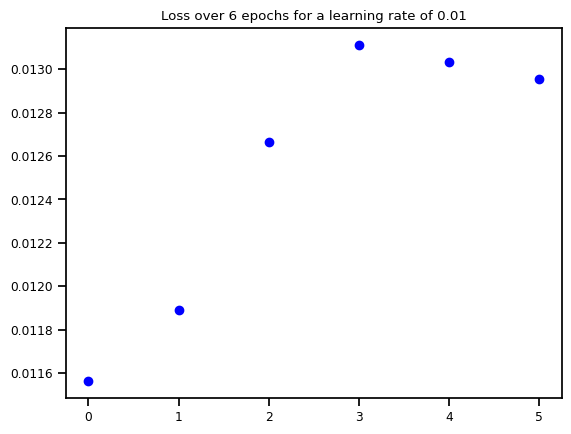

In [12]:

## +++++++++++++++++++++++++ Loss over epochs +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo', label='Training loss')
#plt.ylim([0.7179871796,0.71798718])
#plt.axhline(y=0.7179871780183, color='blue', linestyle='-', label='Training loss')

plt.title(f"Loss over {num_epochs} epochs for a learning rate of {learning_rate}")
plt.show()

#### Loss function observation

Text(0.5, 0.92, 'Loss function: squared difference')

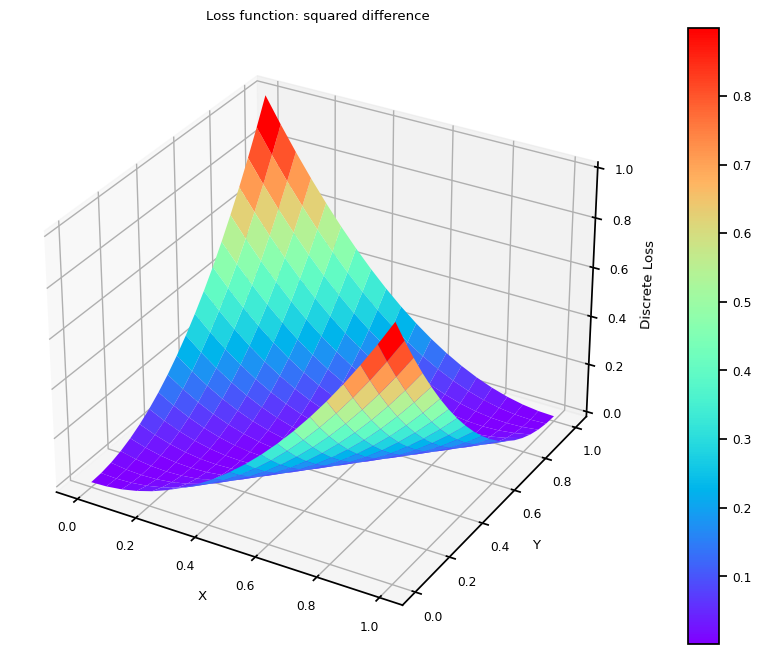

In [13]:

def discrete_loss(Y_prediction, Y_target):
    return (((Y_prediction - Y_target)**2))

grid_x, grid_y = np.mgrid[0:1:20j, 0:1:20j]

values = discrete_loss(grid_x, grid_y)
fig, ax = plt.subplots(nrows=1, ncols=1, num=0, figsize=(16, 8),
                       subplot_kw={'projection': '3d'})
pSurf = ax.plot_surface(grid_x, grid_y, values, rstride=1, cstride=1, cmap='rainbow')
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(x, y, z)
fig.colorbar(pSurf)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Discrete Loss')
ax.set_title("Loss function: squared difference")